## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    Phonon,
    Pulse,
    SequentialProtocol,
    System,
    Transition,
)

from oqd_trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, estate],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 0.1,
    detuning=0,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 0.1,
    detuning=0,
    phase=np.pi,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

T = 10
step = 0.4

protocol = SequentialProtocol(
    sequence=[
        Pulse(beam=beam, duration=step)
        if i % 2 == 0
        else Pulse(beam=beam2, duration=step)
        for i in range(np.ceil(T // step).astype(int))
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("9b_example_floquet_fast.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("9b_example_floquet_fast.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend(solver_options=dict(progress_bar=True))

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

### Results


In [7]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.3%. Run time:   0.32s. Est. time left: 00:00:00:02
20.5%. Run time:   0.67s. Est. time left: 00:00:00:02
30.8%. Run time:   1.10s. Est. time left: 00:00:00:02
41.0%. Run time:   1.53s. Est. time left: 00:00:00:02
51.3%. Run time:   1.95s. Est. time left: 00:00:00:01
61.5%. Run time:   2.38s. Est. time left: 00:00:00:01
71.8%. Run time:   2.81s. Est. time left: 00:00:00:01
82.1%. Run time:   3.23s. Est. time left: 00:00:00:00
92.3%. Run time:   3.66s. Est. time left: 00:00:00:00
100.0%. Run time:   3.99s. Est. time left: 00:00:00:00
Total run time:   3.99s
10.3%. Run time:   0.40s. Est. time left: 00:00:00:03
20.5%. Run time:   0.76s. Est. time left: 00:00:00:02
30.8%. Run time:   1.13s. Est. time left: 00:00:00:02
41.0%. Run time:   1.49s. Est. time left: 00:00:00:02
51.3%. Run time:   1.86s. Est. time left: 00:00:00:01
61.5%. Run time:   2.23s. Est. time left: 00:00:00:01
71.8%. Run time:   2.60s. Est. time left: 00:00:00:01
82.1%. Run time:   2.96s. Est. time left: 00:00:00:00
92.

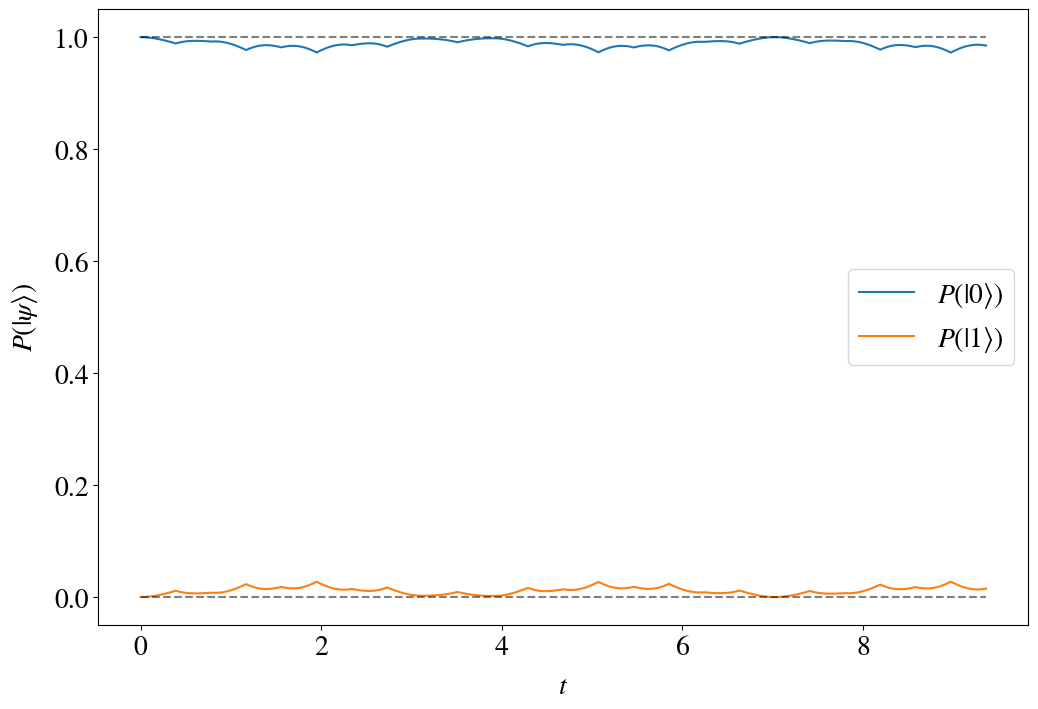

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:] for s in result["states"][k]],
    label=[rf"$P(|{i}\rangle)$" for i in range(2)],
)

ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

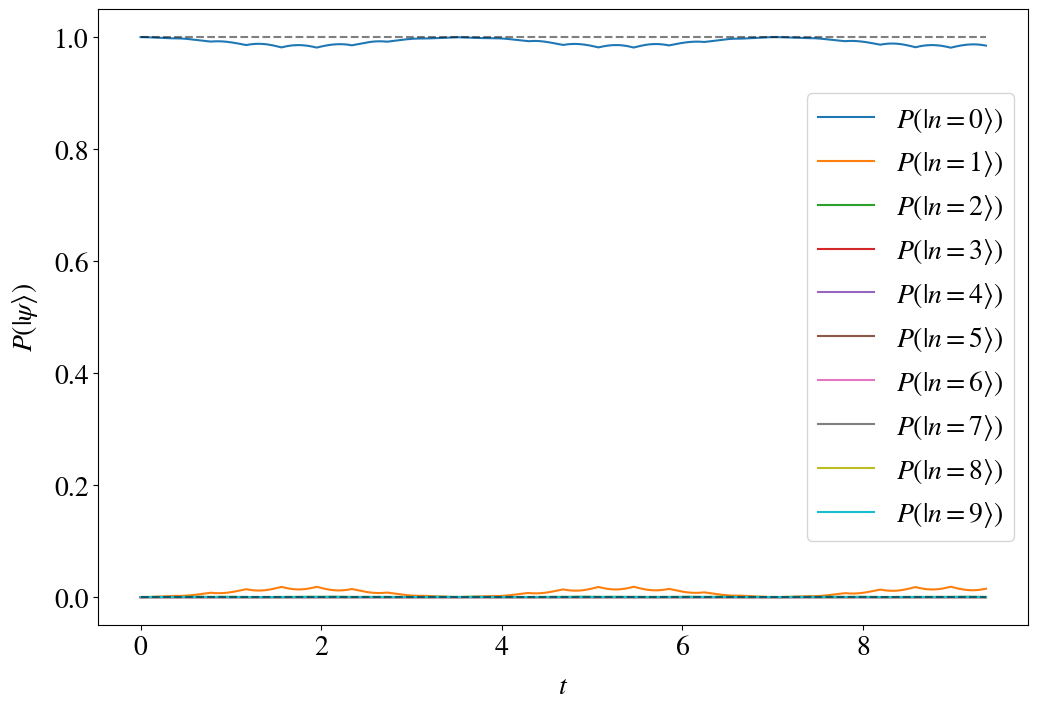

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:] for s in result["states"][k]],
    label=[rf"$P(|n={i}\rangle)$" for i in range(10)],
)

ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()